In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform
import models.SIR as SIR

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[GpuDevice(id=0), GpuDevice(id=1), GpuDevice(id=2), GpuDevice(id=3)]


# Process Data

In [5]:
# Confirmed, Recovered and Death Cases
IRD = transform.IRD(min_confirmed=100, min_recovered=0, min_deaths=0)

In [6]:
min_days = 28
max_days = 60
cases = {}
recoveries = {}
deaths = {}
start_days = np.argmax((IRD[0].values>=30),axis=1)
for i, country in enumerate(IRD[0].index):
    if len(IRD[0].T[country].values[start_days[i]:])>=min_days:
        time_slice = slice(start_days[i], start_days[i]+max_days, 1)
        
        cases[country] = np.array(IRD[0].T[country].values[time_slice]).astype(np.float32)
        recoveries[country] = np.array(IRD[1].T[country].values[time_slice]).astype(np.float32)
        deaths[country] = np.array(IRD[2].T[country].values[time_slice]).astype(np.float32)

In [7]:
pops = transform.population()

Number of unmatched regions : 43
Population data saved @ /data/COVID-19/covid19/data/population/populations.csv


In [8]:
len(cases), len(IRD[0])

(24, 117)

Text(0, 0.5, 'Cumulative Death Cases')

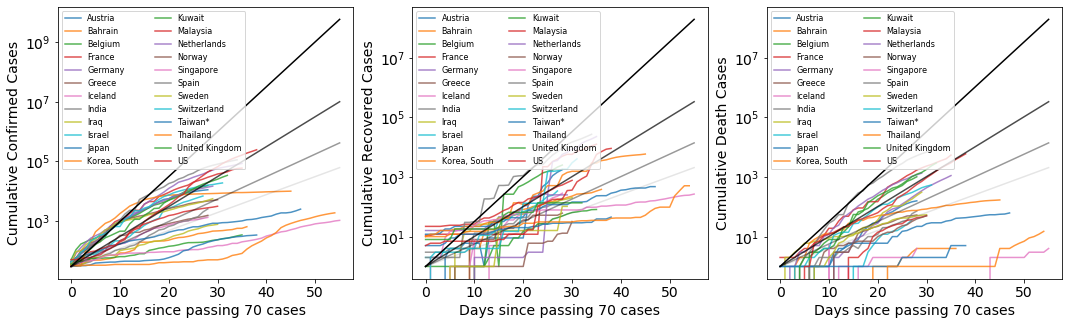

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
t = np.arange(np.max([len(cases[c]) for c in cases.keys()]))
for i, c in enumerate(cases.keys()):
    if len(cases[c])>21:
        ax[0].semilogy(cases[c], alpha = 0.8, label=c)
        ax[1].semilogy(recoveries[c], alpha = 0.8, label=c)
        ax[2].semilogy(deaths[c], alpha = 0.8, label=c)

for [a, start] in zip(ax, [30, 1, 1]):
    a.set_xlabel('Days since passing 70 cases')
    a.legend(ncol=2, fontsize=8)
    for i in range(2, 6):
        a.semilogy(t, start*(2.0**(1.0/float(i)))**t, 'k', alpha=1.0-(i-2)*0.3, label=f'DR: {i} days')

ax[0].set_ylabel('Cumulative Confirmed Cases')
ax[1].set_ylabel('Cumulative Recovered Cases')
ax[2].set_ylabel('Cumulative Death Cases')

In [9]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(mean, std))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

In [10]:
def halfnormHP(name, mean, std, N_child):
    
    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.HalfNormal(mean))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

In [11]:
def model():
    
    N = len(cases)
    
    ############  
    # Initial Infection Rate
    Ii = normalHP('Ii', 100.0, 50.0, N)
    # Initial Removed Rate
    Ri = normalHP('Ri', 10.0, 5.0, N)
    # beta
    R0 = normalHP('R0', 2.5, 1.0, N)
    # gamma
    Tr = normalHP('Tr', 20.0, 10.0, N)
#     # beta
#     beta = halfnormHP('beta', 0.1, 0.05, N)
#     # gamma
#     gamma = halfnormHP('gamma', 0.05, 0.03, N)
    
    # Create likelihood for each country
    for i, country in enumerate(list(cases.keys())):
        
        N_pop = pops.T[country].values[0]
        N_days = len(cases[country])
        removed = recoveries[country] + deaths[country]
        infections = cases[country] - removed
        beta = R0[i]/Tr[i]
        gamma = 1.0/Tr[i]
        prediction = SIR.SIR(N_pop, Ii[i], Ri[i], beta, gamma, N_days)
        
        # Likelihood
        numpyro.sample(country+'_I', dist.Poisson(prediction[:,1]), # SIR model
                       obs=infections)
        numpyro.sample(country+'_R', dist.Poisson(prediction[:,2]), # SIR model
                       obs=removed)

In [12]:
N = len(cases)          
init_params = {'Ii_grp_mean': 100.0*np.ones((N_chains, 1)),
               'Ii_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'Ii_ind': 100.0*np.ones((N_chains, N)),
               'Ri_grp_mean': 10.0*np.ones((N_chains, 1)),
               'Ri_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'Ri_ind': 10.0*np.ones((N_chains, N)),
               'R0_grp_mean': 2.5*np.ones((N_chains, 1)),
               'R0_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'R0_ind': 2.5*np.ones((N_chains, N)),
               'Tr_grp_mean': 20.0*np.ones((N_chains, 1)),
               'Tr_grp_sigma': 1.0*np.ones((N_chains, 1)),
               'Tr_ind': 20.0*np.ones((N_chains, N))
#                'beta_grp_mean': 0.1*np.ones((N_chains, 1)),
#                'beta_grp_sigma': 0.001*np.ones((N_chains, 1)),
#                'beta_ind': 0.1*np.ones((N_chains, N)),
#                'gamma_grp_mean': 0.05*np.ones((N_chains, 1)),
#                'gamma_grp_sigma': 0.001*np.ones((N_chains, 1)),
#                'gamma_ind': 0.05*np.ones((N_chains, N))
               }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [13]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

Time taken to compile model and draw samples : 41903.08400821686 s


In [14]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4_SIRsamples.h5', 'w') as fp:
    for key in samples:
        fp[key] = samples[key]
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
 Ii_grp_mean[0]    100.02      0.28     99.97     99.64    100.58      2.51      3.12
Ii_grp_sigma[0]    271.95     23.68    272.90    233.71    305.53     27.46      1.14
      Ii_ind[0]    178.20     45.82    161.89    117.90    234.19      2.12      5.89
      Ii_ind[1]     97.68      2.50     98.53     93.39    100.01      2.05      9.32
      Ii_ind[2]    107.96      8.11    105.46    100.04    122.80      2.11      7.95
      Ii_ind[3]    359.20      2.66    359.28    354.63    363.30     39.16      1.06
      Ii_ind[4]    459.34      2.87    459.02    455.30    464.38     10.21      1.29
      Ii_ind[5]     99.49      0.74     99.68     98.31    100.35      2.01     14.54
      Ii_ind[6]     98.46      1.27     99.21     96.32     99.48      2.01     25.18
      Ii_ind[7]     96.20      2.51     96.39     92.24     99.57      2.08     11.57
      Ii_ind[8]     97.10      1.71     96.76     94.

Number of divergences: 3305


In [15]:
samples = {}
with h5py.File('../data/nb_samples/4_SIRsamples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)].value

/usr/local/lib/python3.6/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


# $R_0$ for all regions together

Text(0.5, 0, '$R_0$ [infections/person]')

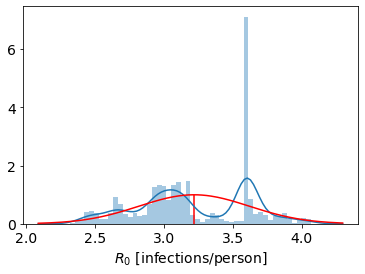

In [17]:
# smp = samples['beta_grp_mean']/samples['gamma_grp_mean']
smp = samples['R0_grp_mean']
mn, std = norm.fit(smp)
sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
plt.vlines(mn, 0, norm.pdf(mn, mn, std), 'r')

plt.xlabel(r'$R_0$ [infections/person]')

# Typical time to removal for all regions together

Text(0.5, 0, 'Typical time to removal [days]')

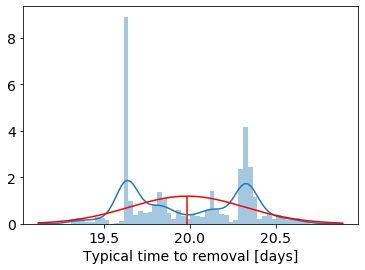

In [18]:
# smp = 1.0/samples['gamma_grp_mean']
smp = samples['Tr_grp_mean']
mn, std = norm.fit(smp)
sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
plt.vlines(mn, 0, norm.pdf(mn, mn, std), 'r')

plt.xlabel(r'Typical time to removal [days]')

In [22]:
len(cases), max([len(cases[c]) for c in cases])

(77, 28)

# Growth rates for each region

(1.0, 10.0)

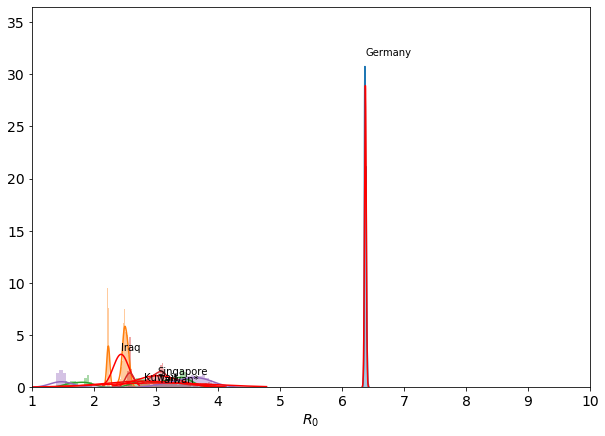

In [20]:
plt.figure(figsize=(10,7))
l_b, u_b = 1.0, 10.0

for i in range(N):
    if i%4==0:
#         smp = samples['beta_ind'][:,i]/samples['gamma_ind'][:,i]
        smp = samples['R0_ind'][:,i]
        mn, std = norm.fit(smp)
        if l_b<mn<u_b:
            sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
            plt.text(mn, 1.1*norm.pdf(mn, mn, std), list(cases.keys())[i], fontsize=10)

plt.xlabel(r'$R_0$')
plt.xlim(l_b, u_b)

# Time to removal for each region

Text(0.5, 0, '$R_0$')

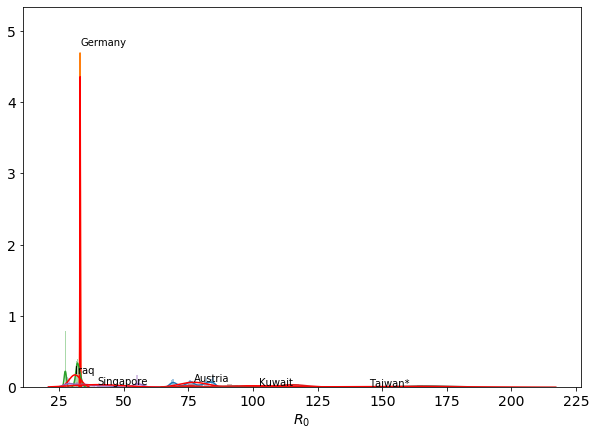

In [23]:
plt.figure(figsize=(10,7))
l_b, u_b = 10.0, 30.0

for i in range(N):
    if i%4==0:
        smp = samples['Tr_ind'][:,i]
        mn, std = norm.fit(smp)
#         if l_b<mn<u_b:
        sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
        plt.text(mn, 1.1*norm.pdf(mn, mn, std), list(cases.keys())[i], fontsize=10)

plt.xlabel(r'$R_0$')
# plt.xlim(l_b, u_b)

# Growth rates for each region if recovery time is 28 days

(1.0, 10.0)

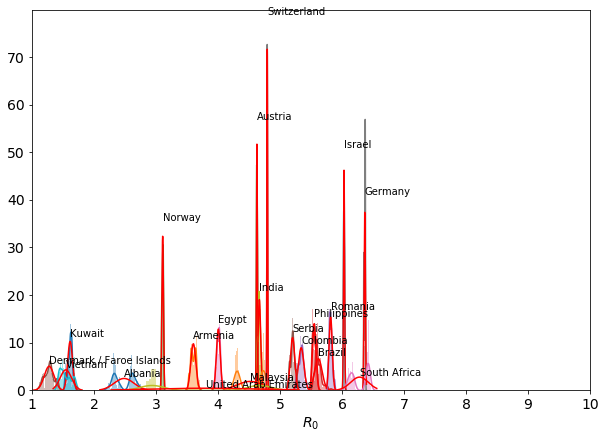

In [26]:
plt.figure(figsize=(10,7))
l_b, u_b = 1.0, 10.0

for i in range(N):
    if i%4==0:
        smp = 28*samples['beta_ind'][:,i]
        mn, std = norm.fit(smp)
        if l_b<mn<u_b:
            sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
            plt.text(mn, 1.1*norm.pdf(mn, mn, std), list(cases.keys())[i], fontsize=10)

plt.xlabel(r'$R_0$')
plt.xlim(l_b, u_b)